# System Definition

### Baseline

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MassDamperSystem:
    """
    1D mass-damper system with state [x, x_dot].
    """
    def __init__(self, m=1.0, b=5.0, x0=0.0, xdot0=0.0):
        self.m = m
        self.b = b
        self.x = x0
        self.xdot = xdot0

    def reset(self, x0=0.0, xdot0=0.0):
        self.x = x0
        self.xdot = xdot0

    def step(self, force, dt):
        xddot = (force - self.b * self.xdot) / self.m
        self.xdot += xddot * dt
        self.x += self.xdot * dt
        return self.x, self.xdot

class Controller:
    def compute_control(self, x, xdot, x_ref, dt, cycle):
        raise NotImplementedError("Subclass must implement compute_control()")

class PIDController(Controller):
    def __init__(self, Kp=3.0, Ki=0.0, Kd=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral_error = 0.0
        self.prev_error = 0.0

    def compute_control(self, x, xdot, x_ref, dt, cycle):
        error = x_ref - x
        self.integral_error += error * dt
        d_error = (error - self.prev_error) / dt if dt > 0 else 0.0
        self.prev_error = error

        # PID control
        f_pid = self.Kp * error + self.Ki * self.integral_error + self.Kd * d_error
        return f_pid

### RBFN Adaptive Learning

In [2]:
class RBFController(Controller):
    def __init__(self, eta=6.0, n_rbf=3, centers=np.linspace(0, 1, 3), sigma=0.3, 
                forgetting_factor=1.0, initial_weights=None, train=True):
        """
        :param n_rbf: number of RBF units
        :param centers: array of RBF centers (if None, we'll set a default)
        :param sigma: RBF width
        :param eta: learning rate
        :param forgetting_factor: factor to scale old weights each update
        """
        self.n_rbf = n_rbf
        self.centers = centers
        self.sigma = sigma
        self.eta = eta
        self.forgetting_factor = forgetting_factor
        self.train = train

        if initial_weights is not None:
            self.weights = initial_weights.copy()
        else:
            self.weights = np.zeros(n_rbf)

    def compute_rbf_outputs(self, x_ref):
        """Compute Gaussian RBF outputs for a given reference x_ref."""
        return np.exp(-((x_ref - self.centers)**2) / (2 * self.sigma**2))

    def compute_control(self, x, xdot, x_ref, dt, cycle):
        """
        Returns the RBF 'assist' force and (optionally) updates the network's weights
        based on the tracking error (x_ref - x).
        """
        error = x_ref - x
        phi = self.compute_rbf_outputs(x_ref)
        f_rbfn = np.dot(self.weights, phi)

        # Only update weights if training is True
        if self.train:
            if cycle < 6:
                self.weights = self.weights + self.eta*error*phi*dt
            else:
                self.weights = self.forgetting_factor * self.weights + self.eta*error*phi*dt

        return f_rbfn

### Disturbance & Gradient Descent Training

In [3]:
class Disturbance(Controller):
    def __init__(self, amplitude=2.0, switch_point=1.5):
        self.amplitude = amplitude
        self.switch_point = switch_point

    def compute_control(self, x, xdot, x_ref, dt, cycle):
        return -self.amplitude if x_ref < self.switch_point else self.amplitude
    
class GradientDescentController(Controller):
    """
    The resist weights are updated using the gradient:
      grad_cost = (W1 - 2 * W2 * error * dt) * phi
    where:
      - phi are the RBF outputs,
      - error = (x_ref - x),
      - W1 and W2 are cost weights.
    """
    def __init__(self, assist_weights, centers, sigma, eta_resist, W1, W2, initial_resist_weights=None):
        """
        :param W1: cost weight for the assist and resist forces
        :param W2: cost weight for the squared error term
        :param initial_resist_weights: (optional) initial resist weights; defaults to zeros.
        """
        self.assist_weights = assist_weights.copy()  # Fixed pre-trained assist weights
        self.centers = centers
        self.sigma = sigma
        self.eta_resist = eta_resist
        self.W1 = W1
        self.W2 = W2
        if initial_resist_weights is not None:
            self.resist_weights = initial_resist_weights.copy()
        else:
            self.resist_weights = np.zeros(len(centers))
        self.cost_history = []  # To log the cost over time if desired

    def compute_rbf_outputs(self, x_ref):
        return np.exp(-((x_ref - self.centers)**2) / (2 * self.sigma**2))

    def compute_control(self, x, xdot, x_ref, dt, cycle):
        error = x_ref - x
        # Compute RBF outputs
        phi = self.compute_rbf_outputs(x_ref)
        # Compute assist force using fixed pre-trained weights
        f_assist = np.dot(self.assist_weights, phi)
        f_resist = np.dot(self.resist_weights, phi)
        # Compute the combined cost (for monitoring purposes)
        cost = self.W1 * (f_assist + f_resist) + self.W2 * (error ** 2)
        self.cost_history.append(cost)
        # Compute gradient of cost with respect to the resist weights:
        grad_cost = (self.W1 - 2 * self.W2 * error * dt) * phi
        # Update resist weights via gradient descent
        self.resist_weights -= self.eta_resist * grad_cost
        u_total = f_assist + f_resist

        return u_total

### Simulator

In [4]:
def get_human_force(duration, x, x_ref, human_type="A"):
    """Compute human force (N) based on different profile types."""
    if human_type == "A":
        return 0.0
    elif human_type == "B":
        return 5.0
    elif human_type == "C":
        return 1.0 * (x_ref - x)
    elif human_type == "D":
        return 10.0 * (x_ref - x)
    elif human_type == "E":
        return 1.0 + 1.0 * np.sin(2 * np.pi * 0.3 * duration)
    return 0.0

class Simulator:
    def __init__(self, system, controllers, human_type="A"):
        """
        :param system: An instance of MassDamperSystem
        :param controllers: List of Controller instances (e.g., [PIDController, RBFController])
        :param human_type: Which human force profile to use
        """
        self.system = system
        self.controllers = controllers if isinstance(controllers, list) else [controllers]
        self.human_type = human_type

        self.all_cycle_sim = []
        self.all_cycle_robot = []
        self.all_cycle_human = []
        self.all_cycle_total = []
        self.all_cycle_weights = []

    def min_jerk_trajectory(self, duration, dt, x0, xf):
        time_vector = np.arange(0, duration, dt)
        tau = time_vector / duration
        x_ref_vector = x0 + (xf - x0) * (10 * tau**3 - 15 * tau**4 + 6 * tau**5)
        return time_vector, x_ref_vector

    def run(self, n_cycles, duration, dt, x0, xf):
        """
        Run multiple cycles of the simulation.
        """
        self.system.reset(x0, 0.0)
        time_vector, x_ref_vector = self.min_jerk_trajectory(duration, dt, x0, xf)

        for cycle in range(n_cycles):
            # Data storage
            x_sim_vector = []
            f_robot_vector = []
            f_human_vector = []
            f_total_vector = []
            error_vector = []

            self.system.reset(x0, 0.0)

            for i, t_current in enumerate(time_vector):
                x_ref = x_ref_vector[i]
                x, xdot = self.system.x, self.system.xdot
                error = x_ref - x

                # Compute total controller force as sum of all controllers
                f_robot = sum(controller.compute_control(x, xdot, x_ref, dt, cycle) for controller in self.controllers)
                f_human = get_human_force(t_current, x, x_ref, self.human_type)
                f_total = f_robot + f_human

                # Step the system
                x_next, xdot_next = self.system.step(f_total, dt)

                # Store data
                x_sim_vector.append(x_next)
                f_robot_vector.append(f_robot)
                f_human_vector.append(f_human)
                f_total_vector.append(f_total)
                error_vector.append(error)

            # Store per-cycle data
            self.all_cycle_sim.append(x_sim_vector)
            self.all_cycle_robot.append(f_robot_vector)
            self.all_cycle_human.append(f_human_vector)
            self.all_cycle_total.append(f_total_vector)
                        
            # Record RBF weights evolution if an RBF controller is present
            for controller in self.controllers:
                if isinstance(controller, RBFController):
                    self.all_cycle_weights.append(controller.weights.copy())
                    break
                elif isinstance(controller, GradientDescentController):
                    self.all_cycle_weights.append(controller.resist_weights.copy())
                    break
                
            print(f"[Simulator Progress] Cycle {cycle + 1}: Error MSE = {np.sum(np.array(error_vector)**2):.4f}")

# Controller Comparison

### Simulation Setup

In [5]:
dt, duration = 0.01, 5.0  # seconds
x0, xf, xdot0 = 0.0, 1.0, 0.0
m, b = 1.0, 5.0
n_rbf, centers, sigma = 3, np.linspace(x0, xf, 3), 0.3

n_cycles = 10
eta = 5
human_type = "C"


# Low P
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
data_lp = Simulator(system, controllers=[low_p_controller], human_type=human_type)
data_lp.run(n_cycles, duration, dt, x0, xf)

# High P
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=30.0, Ki=0.0, Kd=0.0)
data_hp = Simulator(system, controllers=[low_p_controller], human_type=human_type)
data_hp.run(n_cycles, duration, dt, x0, xf)

# Low P + RBFN (with online learing) 
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta, 
                                forgetting_factor=0.999, train=True)
data_lp_rbf = Simulator(system, controllers=[low_p_controller, rbf_controller], human_type=human_type)
data_lp_rbf.run(n_cycles, duration, dt, x0, xf)

weights_lp_rbf = data_lp_rbf.all_cycle_weights[-1]

time_vector, x_ref_vector = data_lp.min_jerk_trajectory(duration, dt, x0, xf)

[Simulator Progress] Cycle 1: Error MSE = 32.2140
[Simulator Progress] Cycle 2: Error MSE = 32.2140
[Simulator Progress] Cycle 3: Error MSE = 32.2140
[Simulator Progress] Cycle 4: Error MSE = 32.2140
[Simulator Progress] Cycle 5: Error MSE = 32.2140
[Simulator Progress] Cycle 6: Error MSE = 32.2140
[Simulator Progress] Cycle 7: Error MSE = 32.2140
[Simulator Progress] Cycle 8: Error MSE = 32.2140
[Simulator Progress] Cycle 9: Error MSE = 32.2140
[Simulator Progress] Cycle 10: Error MSE = 32.2140
[Simulator Progress] Cycle 1: Error MSE = 0.7707
[Simulator Progress] Cycle 2: Error MSE = 0.7707
[Simulator Progress] Cycle 3: Error MSE = 0.7707
[Simulator Progress] Cycle 4: Error MSE = 0.7707
[Simulator Progress] Cycle 5: Error MSE = 0.7707
[Simulator Progress] Cycle 6: Error MSE = 0.7707
[Simulator Progress] Cycle 7: Error MSE = 0.7707
[Simulator Progress] Cycle 8: Error MSE = 0.7707
[Simulator Progress] Cycle 9: Error MSE = 0.7707
[Simulator Progress] Cycle 10: Error MSE = 0.7707
[Simulat

### Simulation Results

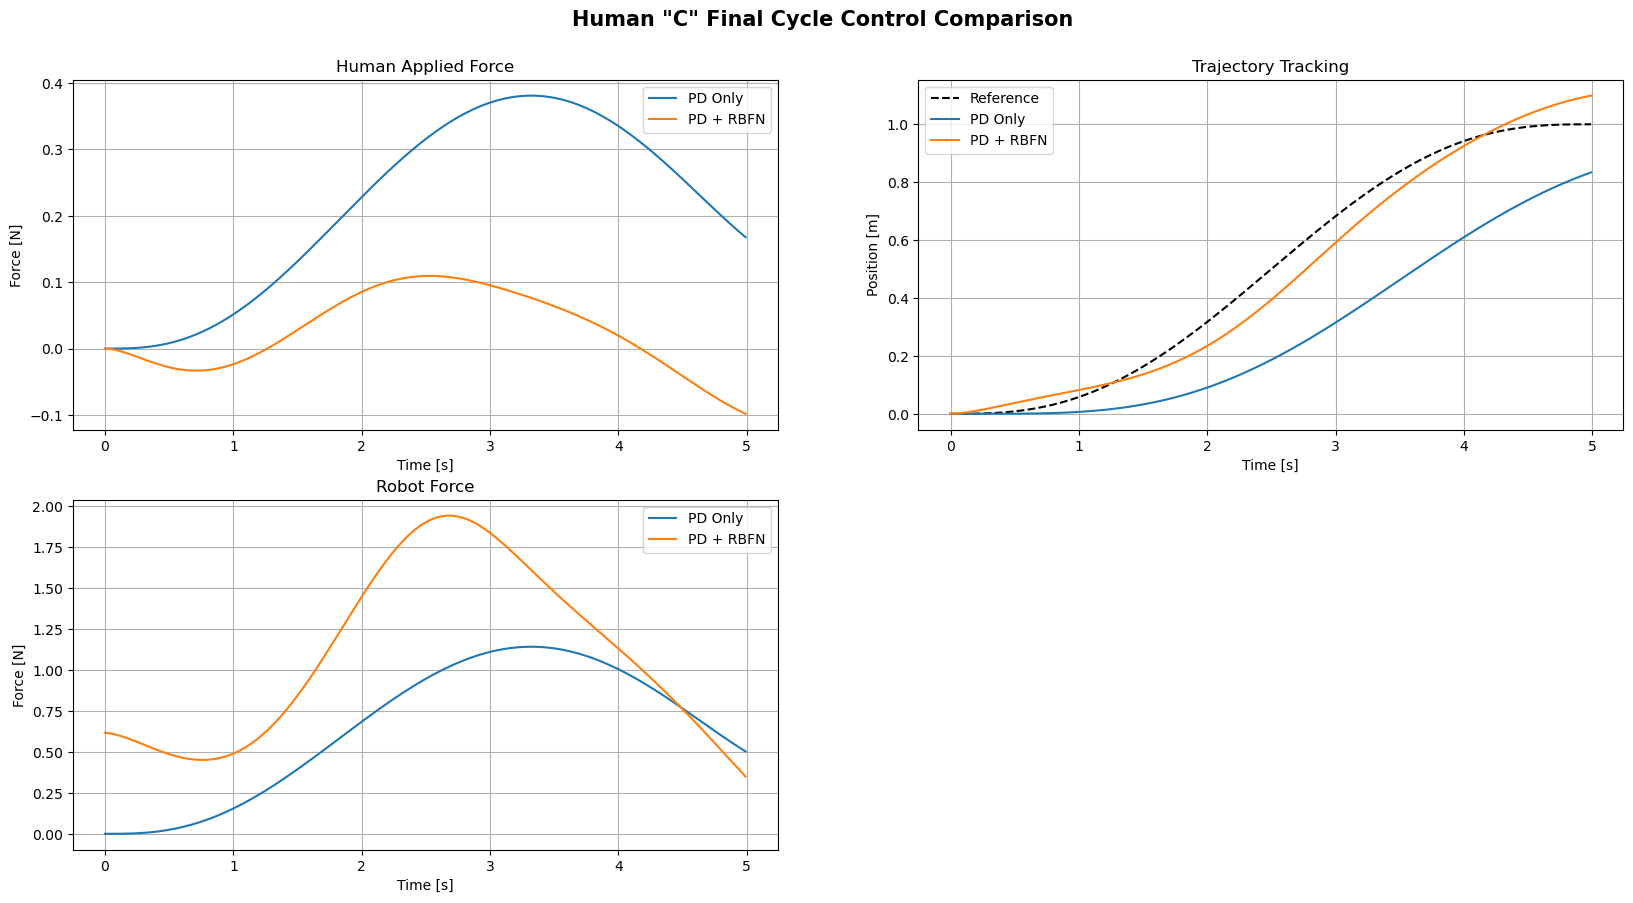

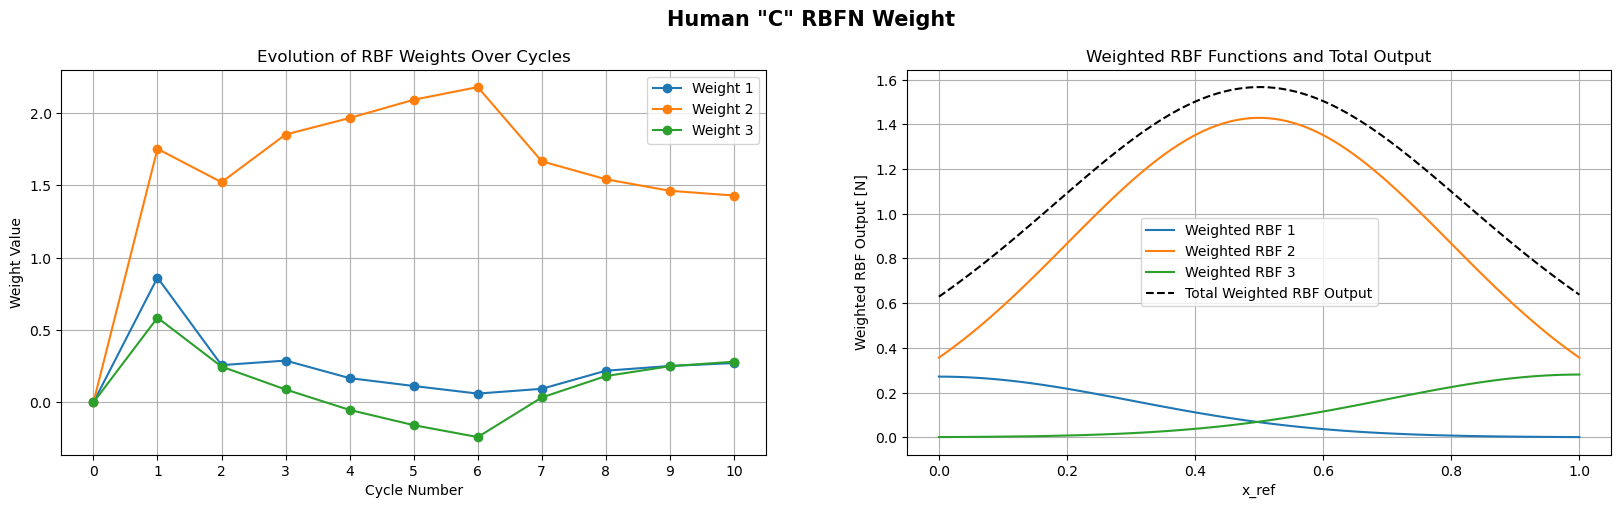

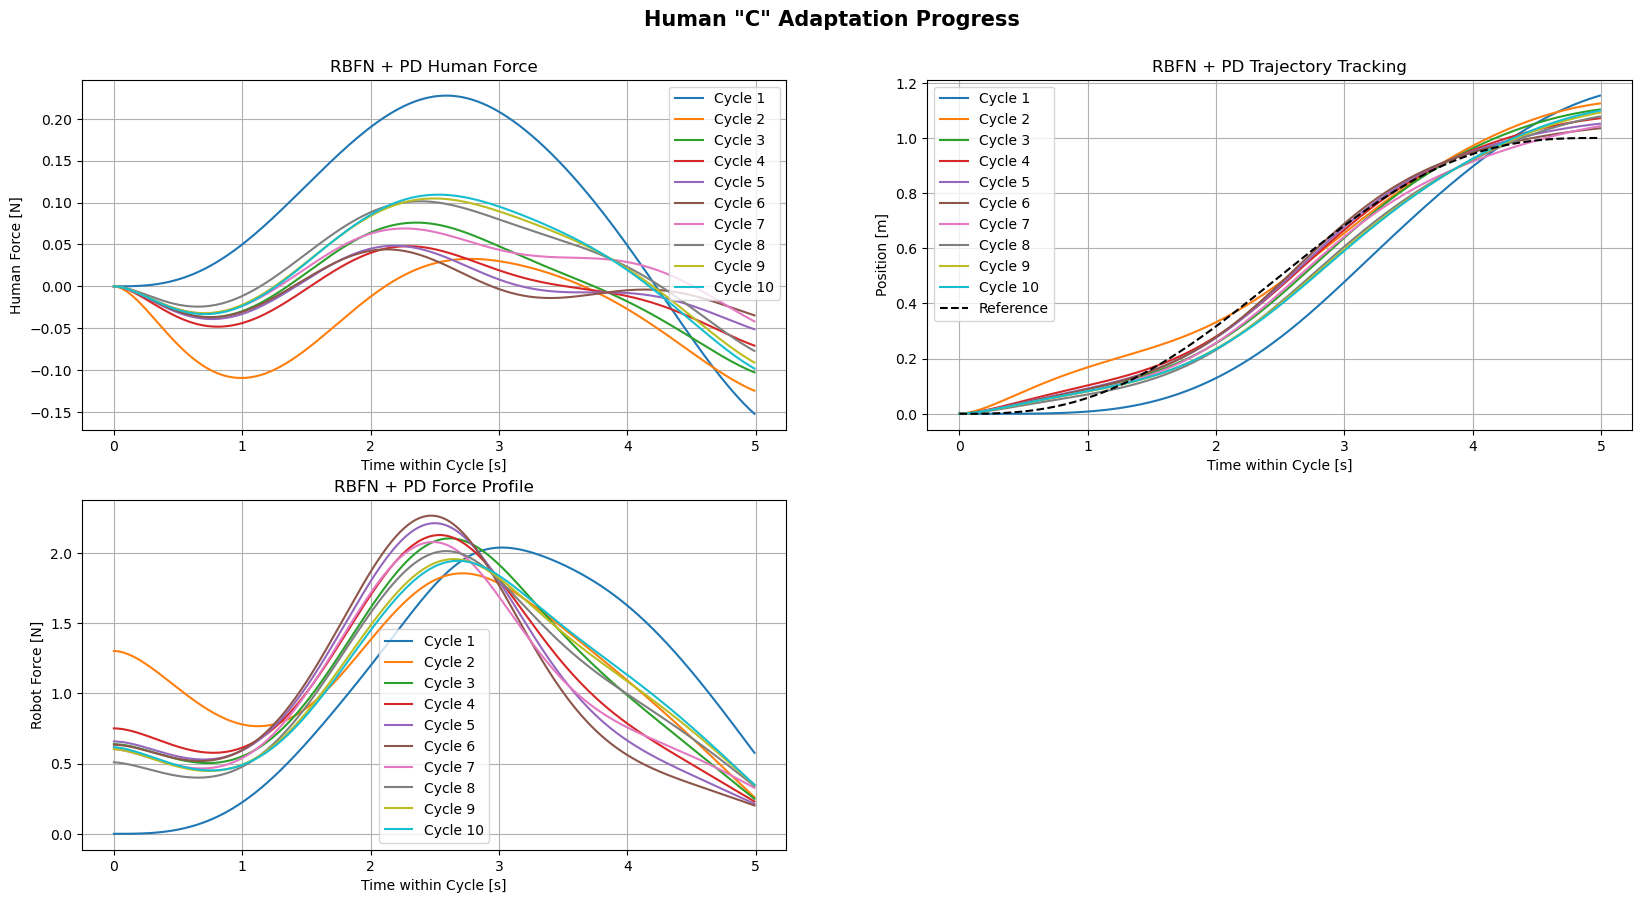

In [6]:
def compute_rbf_outputs(x, centers, sigma):
        return np.exp(-((x - centers)**2) / (2 * sigma**2))

# ========== Plot Final Cycle Comparison ==========
plt.figure(figsize=(20, 10))
plt.suptitle(f'Human "{human_type}" Final Cycle Control Comparison', fontsize=15, fontweight='bold', y=0.95)

# 1. Human Force Comparison
plt.subplot(2, 2, 1)
plt.plot(time_vector, data_lp.all_cycle_human[-1], label='PD Only')
plt.plot(time_vector, data_lp_rbf.all_cycle_human[-1], label='PD + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Human Applied Force')
plt.legend()
plt.grid(True)

# 2. Trajectory Tracking (PD + RBFN)
plt.subplot(2, 2, 2)
plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
plt.plot(time_vector, data_lp.all_cycle_sim[-1], label='PD Only')
plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='PD + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking')
plt.legend()
plt.grid(True)

# 3. Robot Force Comparison
plt.subplot(2, 2, 3)
plt.plot(time_vector, data_lp.all_cycle_robot[-1], label='PD Only')
plt.plot(time_vector, data_lp_rbf.all_cycle_robot[-1], label='PD + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Robot Force')
plt.legend()
plt.grid(True)

# ========== Plot RBF Weights ==========
plt.figure(figsize=(20, 5))
plt.suptitle(f'Human "{human_type}" RBFN Weight', fontweight="bold", fontsize=15, y=1.0)

# 1. Evolution of RBF Weights Over Cycles
plt.subplot(1, 2, 1)
all_cycle_weights_from_zero = np.vstack((np.zeros(n_rbf), np.array(data_lp_rbf.all_cycle_weights)))  # Include cycle 0 (assumed zero weights)
for i in range(n_rbf):
    plt.plot(range(n_cycles+1), all_cycle_weights_from_zero[:, i], marker='o', label=f'Weight {i+1}')
plt.xlabel('Cycle Number')
plt.ylabel('Weight Value')
plt.title('Evolution of RBF Weights Over Cycles')
plt.legend()
plt.grid(True)
plt.xticks(range(n_cycles+1))

# 2. Weighted RBF Functions and Total Output
x_range = np.linspace(0, 1, 100)
phi_matrix = np.zeros((len(x_range), n_rbf))
for i, x_val in enumerate(x_range):
    phi_matrix[i, :] = compute_rbf_outputs(x_val, centers, sigma)
weighted_phi_matrix = phi_matrix * data_lp_rbf.all_cycle_weights[-1]  # using last cycle weights
weighted_total = np.sum(weighted_phi_matrix, axis=1)

plt.subplot(1, 2, 2)
for i in range(n_rbf):
    plt.plot(x_range, weighted_phi_matrix[:, i], label=f'Weighted RBF {i+1}')
plt.plot(x_range, weighted_total, 'k--', label='Total Weighted RBF Output')
plt.xlabel('x_ref')
plt.ylabel('Weighted RBF Output [N]')
plt.title('Weighted RBF Functions and Total Output')
plt.legend()
plt.grid(True)

# ========== Plot All Cycles (PD + RBFN) ==========
plt.figure(figsize=(20, 10))
plt.suptitle(f'Human "{human_type}" Adaptation Progress', fontweight="bold", fontsize=15, y=0.95)

# 1. Human Force per Cycle
plt.subplot(2, 2, 1)
for idx, hf in enumerate(data_lp_rbf.all_cycle_human):
    plt.plot(time_vector, hf, label=f'Cycle {idx+1}')
plt.xlabel('Time within Cycle [s]')
plt.ylabel('Human Force [N]')
plt.title('RBFN + PD Human Force')
plt.legend()
plt.grid(True)

# 2. Trajectory Tracking per Cycle
plt.subplot(2, 2, 2)
for idx, traj in enumerate(data_lp_rbf.all_cycle_sim):
    plt.plot(time_vector, traj, label=f'Cycle {idx+1}')
plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
plt.xlabel('Time within Cycle [s]')
plt.ylabel('Position [m]')
plt.title('RBFN + PD Trajectory Tracking')
plt.legend()
plt.grid(True)

# 3. Total Robot Force (PD + RBFN) per Cycle
plt.subplot(2, 2, 3)
for idx, rf in enumerate(data_lp_rbf.all_cycle_robot):
    plt.plot(time_vector, rf, label=f'Cycle {idx+1}')
plt.xlabel('Time within Cycle [s]')
plt.ylabel('Robot Force [N]')
plt.title('RBFN + PD Force Profile')
plt.legend()
plt.grid(True)

# Compliance Test

### Simulation Setup

In [7]:
dt, duration = 0.01, 5.0  # seconds
x0, xf, xdot0 = 0.0, 1.0, 0.0
m, b = 1.0, 5.0
n_rbf, centers, sigma = 3, np.linspace(x0, xf, 3), 0.3

n_cycles = 10
eta = 5
human_type = "A"

n_finetune_cycles = 5

# High P
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=30.0, Ki=0.0, Kd=0.0)
data_hp = Simulator(system, controllers=[low_p_controller], human_type=human_type)
data_hp.run(n_cycles, duration, dt, x0, xf)

# Low P + RBFN (with online learing) 
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta, 
                                forgetting_factor=1.0, train=True)
data_lp_rbf = Simulator(system, controllers=[low_p_controller, rbf_controller], human_type=human_type)
data_lp_rbf.run(n_cycles, duration, dt, x0, xf)

weights_lp_rbf = data_lp_rbf.all_cycle_weights[-1]

# High P + Disturbance 
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
high_p_controller = PIDController(Kp=30.0, Ki=0.0, Kd=0.0)
disturbance = Disturbance(amplitude=1.0, switch_point=0.5)
data_hp_dist = Simulator(system, controllers=[high_p_controller, disturbance], human_type=human_type)
data_hp_dist.run(n_cycles, duration, dt, x0, xf)

# Low P + RBFN (inference only) + Disturbance 
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta,
                                forgetting_factor=1.0, initial_weights=weights_lp_rbf, train=False)
disturbance = Disturbance(amplitude=1.0, switch_point=0.5)
data_lp_rbf_dist = Simulator(system, controllers=[low_p_controller, rbf_controller, disturbance], human_type=human_type)
data_lp_rbf_dist.run(n_cycles, duration, dt, x0, xf)

time_vector, x_ref_vector = data_lp.min_jerk_trajectory(duration, dt, x0, xf)

[Simulator Progress] Cycle 1: Error MSE = 0.8230
[Simulator Progress] Cycle 2: Error MSE = 0.8230
[Simulator Progress] Cycle 3: Error MSE = 0.8230
[Simulator Progress] Cycle 4: Error MSE = 0.8230
[Simulator Progress] Cycle 5: Error MSE = 0.8230
[Simulator Progress] Cycle 6: Error MSE = 0.8230
[Simulator Progress] Cycle 7: Error MSE = 0.8230
[Simulator Progress] Cycle 8: Error MSE = 0.8230
[Simulator Progress] Cycle 9: Error MSE = 0.8230
[Simulator Progress] Cycle 10: Error MSE = 0.8230
[Simulator Progress] Cycle 1: Error MSE = 11.6692
[Simulator Progress] Cycle 2: Error MSE = 2.7306
[Simulator Progress] Cycle 3: Error MSE = 1.8380
[Simulator Progress] Cycle 4: Error MSE = 0.5320
[Simulator Progress] Cycle 5: Error MSE = 0.4295
[Simulator Progress] Cycle 6: Error MSE = 0.2663
[Simulator Progress] Cycle 7: Error MSE = 0.2484
[Simulator Progress] Cycle 8: Error MSE = 0.2431
[Simulator Progress] Cycle 9: Error MSE = 0.2592
[Simulator Progress] Cycle 10: Error MSE = 0.2787
[Simulator Progre

### Simulation Results

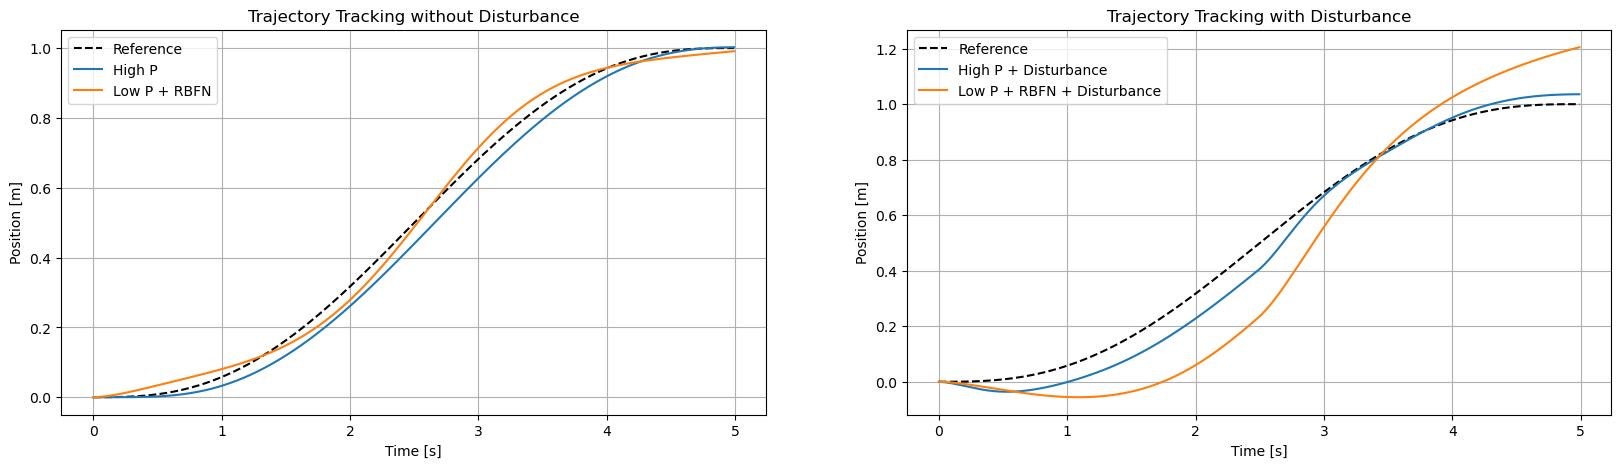

In [8]:
# ========== Compliance Comparison ==========
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
plt.plot(time_vector, data_hp.all_cycle_sim[-1], label='High P')
plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='Low P + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking without Disturbance')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
plt.plot(time_vector, data_hp_dist.all_cycle_sim[-1], label='High P + Disturbance')
plt.plot(time_vector, data_lp_rbf_dist.all_cycle_sim[-1], label='Low P + RBFN + Disturbance')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking with Disturbance')
plt.legend()
plt.grid(True)

plt.show()

###

# Fine Tuning

## 1. Gradient Descent Method

### Simulation Setup

In [9]:
dt, duration = 0.01, 5.0  # seconds
x0, xf, xdot0 = 0.0, 1.0, 0.0
m, b = 1.0, 5.0
n_rbf, centers, sigma = 3, np.linspace(x0, xf, 3), 0.3

n_cycles = 10
eta = 5
human_type = "C"

n_finetune_cycles = 30

# Low P + RBFN (with online learing) 
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta, 
                                forgetting_factor=1.0, train=True)
data_lp_rbf = Simulator(system, controllers=[low_p_controller, rbf_controller], human_type=human_type)
data_lp_rbf.run(n_cycles, duration, dt, x0, xf)

weights_lp_rbf = data_lp_rbf.all_cycle_weights[-1]

# Low P + RBFN (inference only) + Disturbance
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
eta_resist = 0.3    # Learning rate for resist weights (set > 0 to see changes)
W1 = 0.001           # Cost weight for total force
W2 = 1.0            # Cost weight for the squared error term
gd_controller = GradientDescentController(
    assist_weights=weights_lp_rbf,              #  Use the pre-trained assist weights from the previous RBF training
    centers=centers,
    sigma=sigma,
    eta_resist=eta_resist,
    W1=W1,
    W2=W2
)
data_lp_rbf_gd = Simulator(system, controllers=[low_p_controller, gd_controller], human_type=human_type)
data_lp_rbf_gd.run(n_finetune_cycles, duration, dt, x0, xf)

time_vector, x_ref_vector = data_lp.min_jerk_trajectory(duration, dt, x0, xf)

[Simulator Progress] Cycle 1: Error MSE = 9.2320
[Simulator Progress] Cycle 2: Error MSE = 1.9116
[Simulator Progress] Cycle 3: Error MSE = 1.1465
[Simulator Progress] Cycle 4: Error MSE = 0.5427
[Simulator Progress] Cycle 5: Error MSE = 0.3739
[Simulator Progress] Cycle 6: Error MSE = 0.2716
[Simulator Progress] Cycle 7: Error MSE = 0.2359
[Simulator Progress] Cycle 8: Error MSE = 0.2281
[Simulator Progress] Cycle 9: Error MSE = 0.2353
[Simulator Progress] Cycle 10: Error MSE = 0.2486
[Simulator Progress] Cycle 1: Error MSE = 0.1968
[Simulator Progress] Cycle 2: Error MSE = 0.4269
[Simulator Progress] Cycle 3: Error MSE = 0.7258
[Simulator Progress] Cycle 4: Error MSE = 0.9910
[Simulator Progress] Cycle 5: Error MSE = 1.1968
[Simulator Progress] Cycle 6: Error MSE = 1.3460
[Simulator Progress] Cycle 7: Error MSE = 1.4498
[Simulator Progress] Cycle 8: Error MSE = 1.5202
[Simulator Progress] Cycle 9: Error MSE = 1.5671
[Simulator Progress] Cycle 10: Error MSE = 1.5978
[Simulator Progres

### Simulation Results

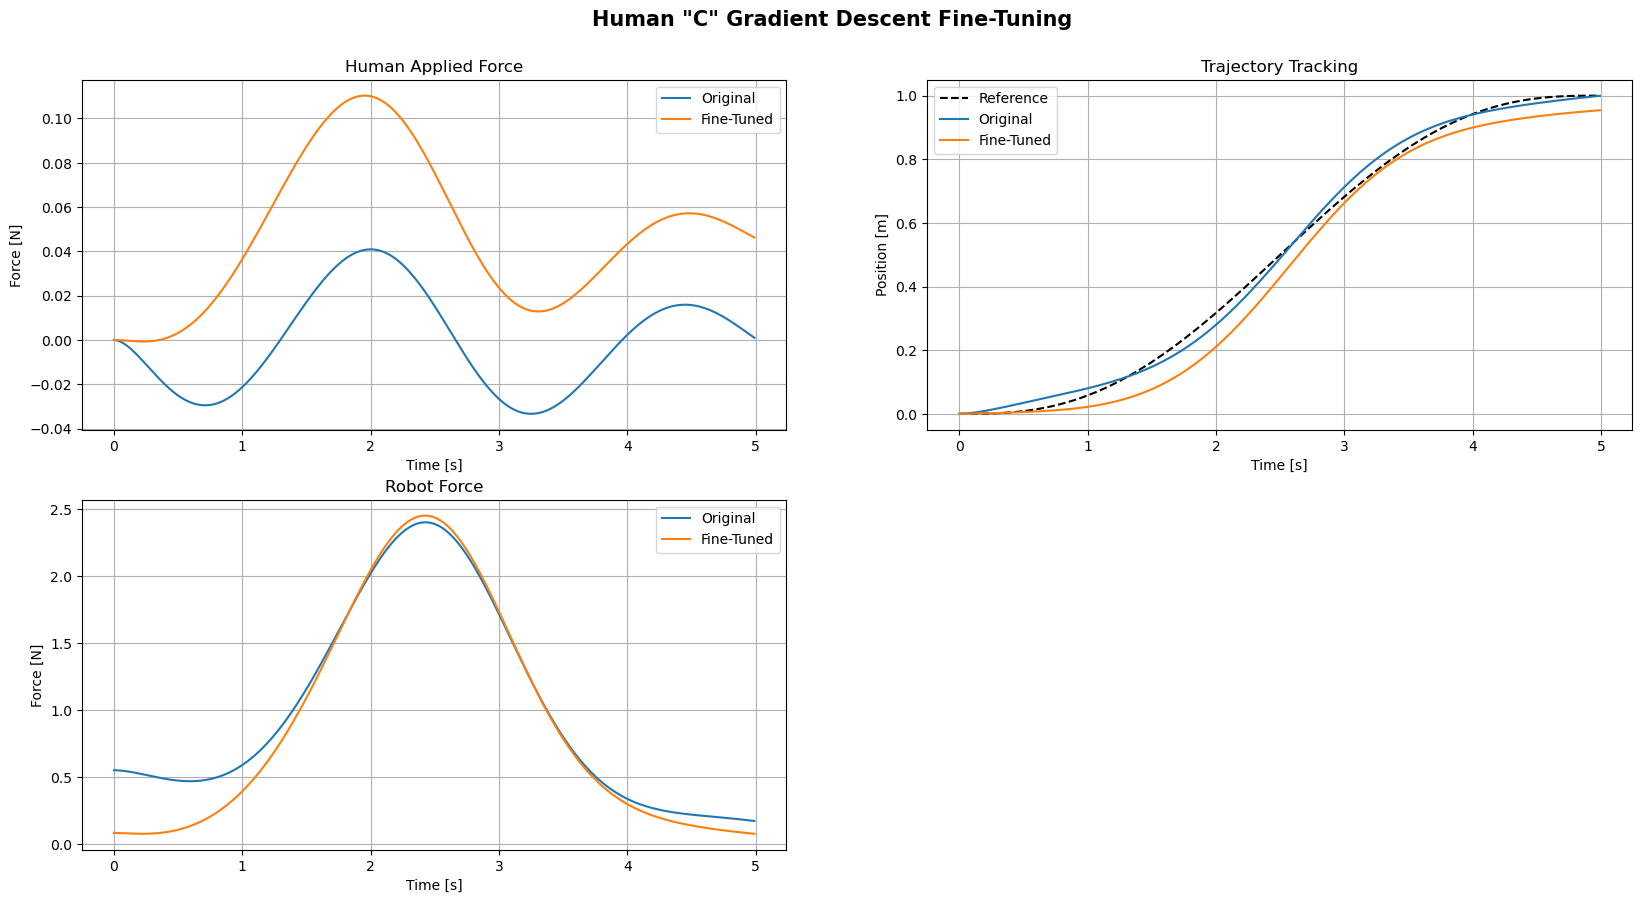

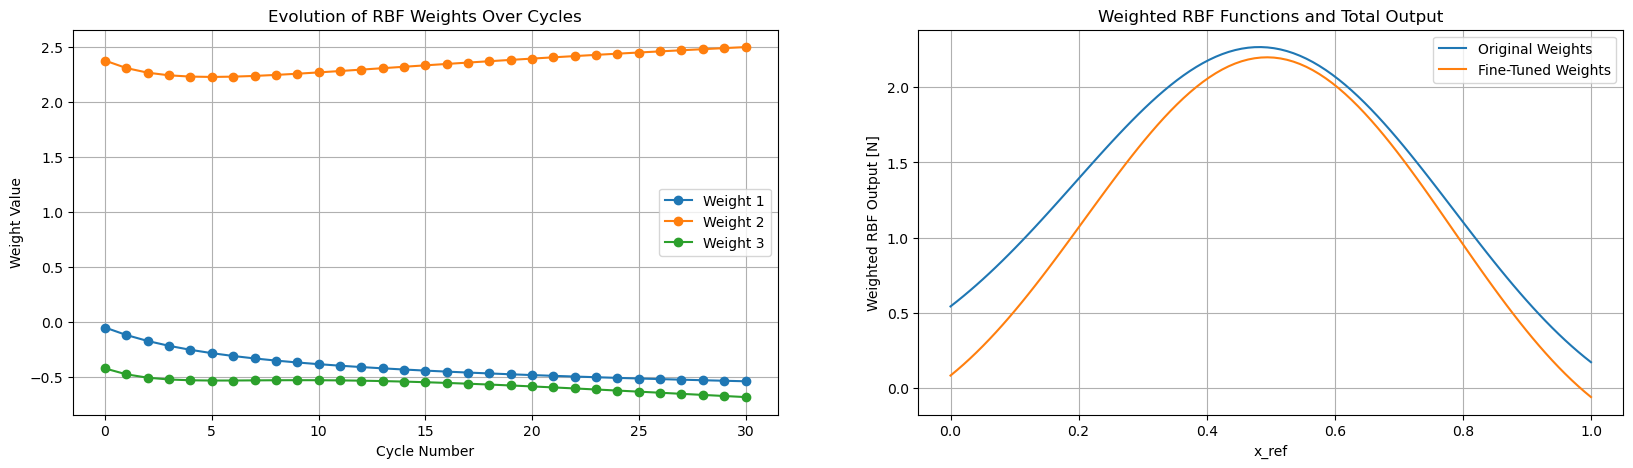

In [10]:
plt.figure(figsize=(20, 10))
plt.suptitle(f'Human "{human_type}" Gradient Descent Fine-Tuning', fontweight="bold", fontsize=15, y=0.95)

# 1. Human Force Comparison
plt.subplot(2, 2, 1)
plt.plot(time_vector, data_lp_rbf.all_cycle_human[-1], label='Original')
plt.plot(time_vector, data_lp_rbf_gd.all_cycle_human[-1], label='Fine-Tuned')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Human Applied Force')
plt.legend()
plt.grid(True)

# 2. Trajectory Tracking
plt.subplot(2, 2, 2)
plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='Original')
plt.plot(time_vector, data_lp_rbf_gd.all_cycle_sim[-1], label='Fine-Tuned')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking')
plt.legend()
plt.grid(True)

# 3. Robot Force Comparison
plt.subplot(2, 2, 3)
plt.plot(time_vector, data_lp_rbf.all_cycle_robot[-1], label='Original')
plt.plot(time_vector, data_lp_rbf_gd.all_cycle_robot[-1], label='Fine-Tuned')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Robot Force')
plt.legend()
plt.grid(True)


# 1. Evolution of RBF Weights Over Cycles
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
x_range = range(n_finetune_cycles+1)
fine_tuned_weights = np.array([data_lp_rbf.all_cycle_weights[-1]]) + np.array(data_lp_rbf_gd.all_cycle_weights)
fine_tunend_weights_from_origin = np.vstack([data_lp_rbf.all_cycle_weights[-1], fine_tuned_weights])

# fine_tuned_weights = np.array([data_lp_rbf.all_cycle_weights[-1]] + data_lp_rbf_gd.all_cycle_weights)
for i in range(n_rbf):
    plt.plot(x_range, fine_tunend_weights_from_origin[:, i], marker='o', label=f'Weight {i+1}')
plt.xlabel('Cycle Number')
plt.ylabel('Weight Value')
plt.title('Evolution of RBF Weights Over Cycles')
plt.legend()
plt.grid(True)

# 2. Total Weighted RBF Functions and Total Output
x_range = np.linspace(0, 1, 100)
phi_matrix = np.zeros((len(x_range), n_rbf))
for i, x_val in enumerate(x_range):
    phi_matrix[i, :] = compute_rbf_outputs(x_val, centers, sigma)

weighted_phi_matrix_original = np.sum(phi_matrix * data_lp_rbf.all_cycle_weights[-1], axis=1)
weighted_phi_matrix_fine_tuned = np.sum(phi_matrix * fine_tunend_weights_from_origin[-1], axis=1)

plt.subplot(1, 2, 2)
plt.plot(x_range, weighted_phi_matrix_original, label='Original Weights')
plt.plot(x_range, weighted_phi_matrix_fine_tuned, label='Fine-Tuned Weights')
plt.xlabel('x_ref')
plt.ylabel('Weighted RBF Output [N]')
plt.title('Weighted RBF Functions and Total Output')
plt.legend()
plt.grid(True)

plt.show()

## 2. Bayesian Optimization

In [11]:
# from bayes_opt import BayesianOptimization
from skopt import gp_minimize
from skopt.space import Real

dt, duration = 0.01, 5.0  # seconds
x0, xf, xdot0 = 0.0, 1.0, 0.0
m, b = 1.0, 5.0
n_rbf, centers, sigma = 3, np.linspace(x0, xf, 3), 0.3

n_cycles = 10
eta = 5
human_type = "C"

n_finetune_cycles = 30

# Low P + RBFN (with online learing) 
system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta, 
                                forgetting_factor=1.0, train=True)
data_lp_rbf = Simulator(system, controllers=[low_p_controller, rbf_controller], human_type=human_type)
data_lp_rbf.run(n_cycles, duration, dt, x0, xf)

time_vector, x_ref_vector = data_lp.min_jerk_trajectory(duration, dt, x0, xf)
weights_lp_rbf = data_lp_rbf.all_cycle_weights[-1]

[Simulator Progress] Cycle 1: Error MSE = 9.2320
[Simulator Progress] Cycle 2: Error MSE = 1.9116
[Simulator Progress] Cycle 3: Error MSE = 1.1465
[Simulator Progress] Cycle 4: Error MSE = 0.5427
[Simulator Progress] Cycle 5: Error MSE = 0.3739
[Simulator Progress] Cycle 6: Error MSE = 0.2716
[Simulator Progress] Cycle 7: Error MSE = 0.2359
[Simulator Progress] Cycle 8: Error MSE = 0.2281
[Simulator Progress] Cycle 9: Error MSE = 0.2353
[Simulator Progress] Cycle 10: Error MSE = 0.2486


In [12]:
class FineTuningSimulator:
    def __init__(self, system, duration, dt, x0, xf, centers, sigma, assist_weights,
                 kp=3.0, ki=0.0, n_cycles=5, force_weight=1.0, error_weight=1.0, human_type="A"):
        """
        :param system: Simulation system object (e.g., MassDamperSystem) that provides reset(x, xdot) and step(force, dt).
        :param duration: Total simulation time (sec)
        :param dt: Time step (sec)
        :param x0: Initial state
        :param xf: Target state
        :param centers: Centers of the RBF units
        :param sigma: Sigma value for the RBF units
        :param assist_weights: Pre-trained Assist weights
        :param kp: PID proportional constant
        :param ki: PID integral constant
        :param n_cycles: Number of fine-tuning cycles
        :param force_weight: Weight for assist and resistance forces (W1)
        :param error_weight: Weight for squared error term (W2)
        :param human_type: Human force profile type
        """
        self.system = system
        self.duration = duration
        self.dt = dt
        self.x0 = x0
        self.xf = xf
        self.centers = centers
        self.sigma = sigma
        self.assist_weights = assist_weights
        self.kp = kp
        self.ki = ki
        self.n_cycles = n_cycles
        self.force_weight = force_weight
        self.error_weight = error_weight
        self.human_type = human_type

        self.n_rbf = len(centers)
        self.resist_weights = np.zeros(self.n_rbf)

        self.all_cycle_sim = []
        self.all_cycle_assist = []
        self.all_cycle_resist = []
        self.all_cycle_robot = []
        self.all_cycle_human = []
        self.all_cycle_resist_weights = []
        self.all_cycle_costs = []

    def min_jerk_trajectory(self):
        """Generate a minimum-jerk reference trajectory."""
        time_vector = np.arange(0, self.duration, self.dt)
        tau = time_vector / self.duration
        x_ref_vector = self.x0 + (self.xf - self.x0) * (10 * tau**3 - 15 * tau**4 + 6 * tau**5)
        return time_vector, x_ref_vector

    def run(self):
        """Execute the fine-tuning cycles."""
        print("\n===== Starting Fine-Tuning (Combined Loss) =====")
        time_vector, x_ref_vector = self.min_jerk_trajectory()

        for cycle in range(self.n_cycles):
            # def objective(**params):
            #     candidate_resist = np.array([params[f"w{i}"] for i in range(self.n_rbf)])
            def objective(candidate_resist):
                candidate_resist = np.array(candidate_resist)
                self.system.reset(self.x0, 0.0)
                integral_error = 0.0
                total_cost = 0.0

                for t in time_vector:
                    x = self.system.x
                    idx = int(t / self.dt)
                    x_ref = x_ref_vector[idx]
                    error = x_ref - x
                    integral_error += error * self.dt

                    u_pid = self.kp * error + self.ki * integral_error
                    phi = compute_rbf_outputs(x_ref, self.centers, self.sigma)

                    f_assist = np.dot(self.assist_weights, phi)
                    f_resist = np.dot(candidate_resist, phi)

                    cost = self.force_weight * (f_assist + f_resist) + self.error_weight * (error ** 2)
                    total_cost += cost

                    u_total = u_pid + f_assist + f_resist
                    f_human = get_human_force(t, x, x_ref, self.human_type)
                    self.system.step(u_total + f_human, self.dt)

                avg_cost = total_cost / len(time_vector)
                return -avg_cost  # Return negative cost for maximization

            # pbounds = {f"w{i}": (-0.5, 0.5) for i in range(self.n_rbf)}
            dimensions = [Real(-0.5, 2, name=f"w{i}") for i in range(self.n_rbf)]

            # optimizer = BayesianOptimization(
            #     f=objective,
            #     pbounds=pbounds,
            #     verbose=0,
            #     random_state=cycle
            # )
            res = gp_minimize(
                objective,
                dimensions,
                acq_func="LCB",                    # Lower Confidence Bound를 사용
                # acq_func_kwargs={"kappa": 0.1},      # 탐색(exploration)보다 활용(exploitation) 비중을 높임
                kappa=0.1,
                n_calls=3,                         # 총 함수 평가 횟수 (초기 포인트 포함)
                n_initial_points=1,                # 초기 무작위 평가 포인트 수
                random_state=cycle
            )

            # optimizer.maximize(init_points=1, n_iter=2, acq="ucb", kappa=0.1)  
            # best_params = optimizer.max['params']
            # best_resist = np.array([best_params[f"w{i}"] for i in range(self.n_rbf)])
            # self.resist_weights = best_resist

            best_resist = np.array(res.x)
            self.resist_weights = best_resist

            

            self.system.reset(self.x0, 0.0)
            integral_error = 0.0
            cycle_sim = []
            cycle_assist = []
            cycle_resist = []
            cycle_robot = []
            cycle_human = []
            cycle_cost = []

            for t in time_vector:
                x = self.system.x
                idx = int(t / self.dt)
                x_ref = x_ref_vector[idx]
                error = x_ref - x
                integral_error += error * self.dt

                u_pid = self.kp * error + self.ki * integral_error
                phi = compute_rbf_outputs(x_ref, self.centers, self.sigma)

                f_assist = np.dot(self.assist_weights, phi)
                f_resist = np.dot(self.resist_weights, phi)
                cost = self.force_weight * (f_assist + f_resist) + self.error_weight * (error ** 2)
                cycle_cost.append(cost)

                u_total = u_pid + f_assist + f_resist
                f_human = get_human_force(t, x, x_ref, self.human_type)
                self.system.step(u_total + f_human, self.dt)

                cycle_sim.append(self.system.x)
                cycle_assist.append(f_assist)
                cycle_resist.append(f_resist)
                cycle_robot.append(u_total)
                cycle_human.append(f_human)

            self.all_cycle_sim.append(cycle_sim)
            self.all_cycle_assist.append(cycle_assist)
            self.all_cycle_resist.append(cycle_resist)
            self.all_cycle_robot.append(cycle_robot)
            self.all_cycle_human.append(cycle_human)
            self.all_cycle_resist_weights.append(self.resist_weights.copy())
            self.all_cycle_costs.append(cycle_cost)

            avg_cycle_cost = np.mean(cycle_cost)
            print(f"Cycle {cycle + 1}: Final Error = {error:.4f}, Average Cost = {avg_cycle_cost:.4f}")
            print(f"    Assist Weights: {self.assist_weights}")
            print(f"    Resist Weights: {self.resist_weights}")


data_lp_rbf_bo = FineTuningSimulator(
    system=system,
    duration=duration,
    dt=dt,
    x0=x0,
    xf=xf,
    centers=centers,
    sigma=sigma,
    assist_weights=weights_lp_rbf,
    kp=3.0,
    ki=0.0,
    n_cycles=n_finetune_cycles,
    force_weight=1.0,
    error_weight=0,
    human_type=human_type
)

data_lp_rbf_bo.run()


===== Starting Fine-Tuning (Combined Loss) =====
Cycle 1: Final Error = -0.5333, Average Cost = 2.9848
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [0.98211155 1.61066437 1.64486404]
Cycle 2: Final Error = -0.2086, Average Cost = 2.7552
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 1.99506486  1.83139208 -0.17964483]
Cycle 3: Final Error = -0.5806, Average Cost = 2.7566
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [-0.03729473  1.8288524   1.86932654]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, -0.5, 2.0] before, using random point [1.1165025433981792, 0.5528244548593078, -0.27042002213930005]
  warnings.warn(


Cycle 4: Final Error = -0.3985, Average Cost = 2.4805
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 2.  -0.5  2. ]
Cycle 5: Final Error = -0.3666, Average Cost = 2.4435
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 1.75155364 -0.06826167  1.63905237]
Cycle 6: Final Error = -0.3985, Average Cost = 2.4805
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 2.  -0.5  2. ]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [-0.5, 2.0, 2.0] before, using random point [1.7238141315211517, 0.39040531910663645, 0.5455504315982389]
  warnings.warn(


Cycle 7: Final Error = -0.6157, Average Cost = 2.7025
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [-0.5  2.   2. ]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, -0.5] before, using random point [0.051144436846707664, 1.0261983643759285, -0.4210446917245765]
  warnings.warn(


Cycle 8: Final Error = -0.1619, Average Cost = 2.7080
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 2.   2.  -0.5]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [-0.3520278937880046, 1.8817615479419239, 1.8010518311482802]
  warnings.warn(


Cycle 9: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [0.6967400658064156, -0.2609310510392291, -0.40279797250806365]
  warnings.warn(


Cycle 10: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [1.3817934443963273, 0.1399233300864975, 0.5232458836462801]
  warnings.warn(


Cycle 11: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, -0.5, 2.0] before, using random point [0.11323193093188333, 0.22319808812939823, 1.809293475943257]
  warnings.warn(


Cycle 12: Final Error = -0.3985, Average Cost = 2.4805
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 2.  -0.5  2. ]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, -0.5, 2.0] before, using random point [-0.27528389547968635, 1.3739518553577263, 0.4560324086532388]
  warnings.warn(


Cycle 13: Final Error = -0.3985, Average Cost = 2.4805
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 2.  -0.5  2. ]
Cycle 14: Final Error = -0.5560, Average Cost = 3.0573
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.01835332 1.64858504 1.73245673]
Cycle 15: Final Error = -0.2512, Average Cost = 2.5738
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.8047336  1.14771223 0.41570599]
Cycle 16: Final Error = -0.0975, Average Cost = 2.0981
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 1.53395112  0.97838749 -0.22253419]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [0.6000054971157371, 1.5521397418829093, -0.19400689292631396]
  warnings.warn(


Cycle 17: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]
Cycle 18: Final Error = -0.5268, Average Cost = 2.5774
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [-0.04555557  1.61058461  1.72216206]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [1.6309592894995233, 0.4458860715781261, -0.447399907625665]
  warnings.warn(


Cycle 19: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, -0.5] before, using random point [0.7919361790127923, 1.6044877204154568, -0.17931818000603483]
  warnings.warn(


Cycle 20: Final Error = -0.1619, Average Cost = 2.7080
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 2.   2.  -0.5]
Cycle 21: Final Error = -0.6269, Average Cost = 3.5433
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.71852926 1.88610292 1.8806944 ]
Cycle 22: Final Error = -0.0827, Average Cost = 2.1175
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 1.49817967  1.19960545 -0.40963081]
Cycle 23: Final Error = -0.3964, Average Cost = 2.7196
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.25490745 1.32626721 1.09369784]
Cycle 24: Final Error = -0.3200, Average Cost = 2.1326
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [ 1.17274281 -0.03752878  1.45419876]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [0.9849094191817767, 1.6869983674748097, 1.723309057176344]
  warnings.warn(


Cycle 25: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [-0.5, 2.0, 2.0] before, using random point [1.5330146549237917, 1.80529450660697, 1.4394820756064406]
  warnings.warn(


Cycle 26: Final Error = -0.5246, Average Cost = 3.2340
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.53301465 1.80529451 1.43948208]
Cycle 27: Final Error = -0.2393, Average Cost = 2.0850
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.28277808 0.23729123 0.89834947]
Cycle 28: Final Error = -0.3485, Average Cost = 2.5405
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [0.70200377 1.78730114 0.66989419]


c:\Users\realf\miniconda3\envs\pyexp\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 2.0, 2.0] before, using random point [0.4514832686221011, 1.9796084128645206, -0.10967697006173233]
  warnings.warn(


Cycle 29: Final Error = -0.6695, Average Cost = 3.7737
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [2. 2. 2.]
Cycle 30: Final Error = -0.4692, Average Cost = 2.6961
    Assist Weights: [-0.0487434   2.3775153  -0.42076173]
    Resist Weights: [1.50131304 0.39144113 1.92521337]


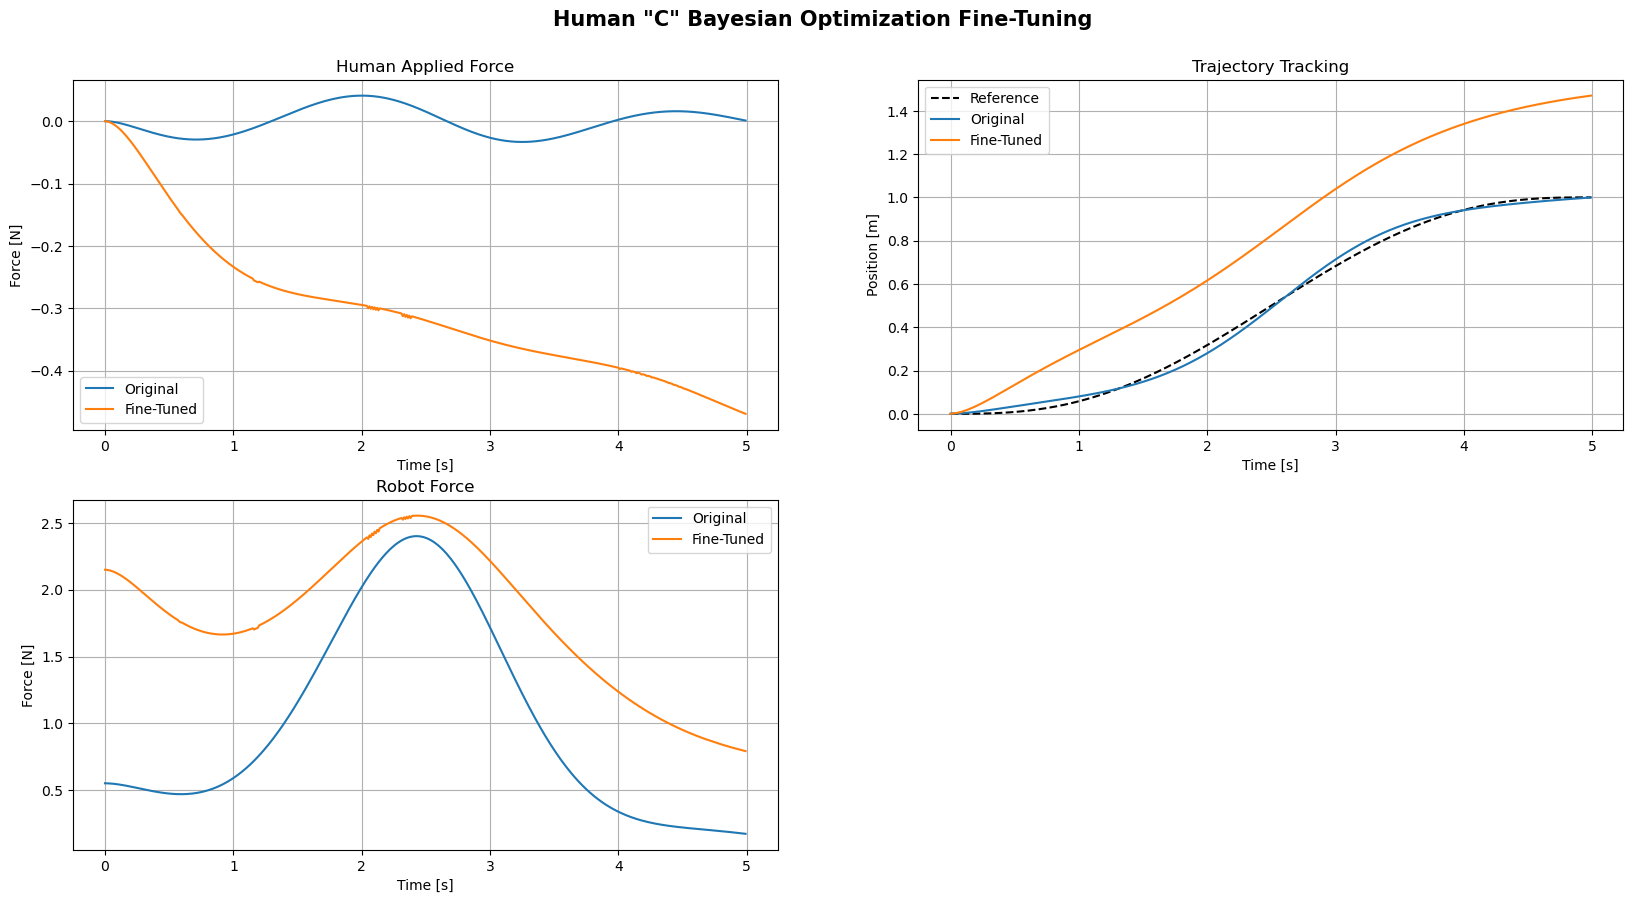

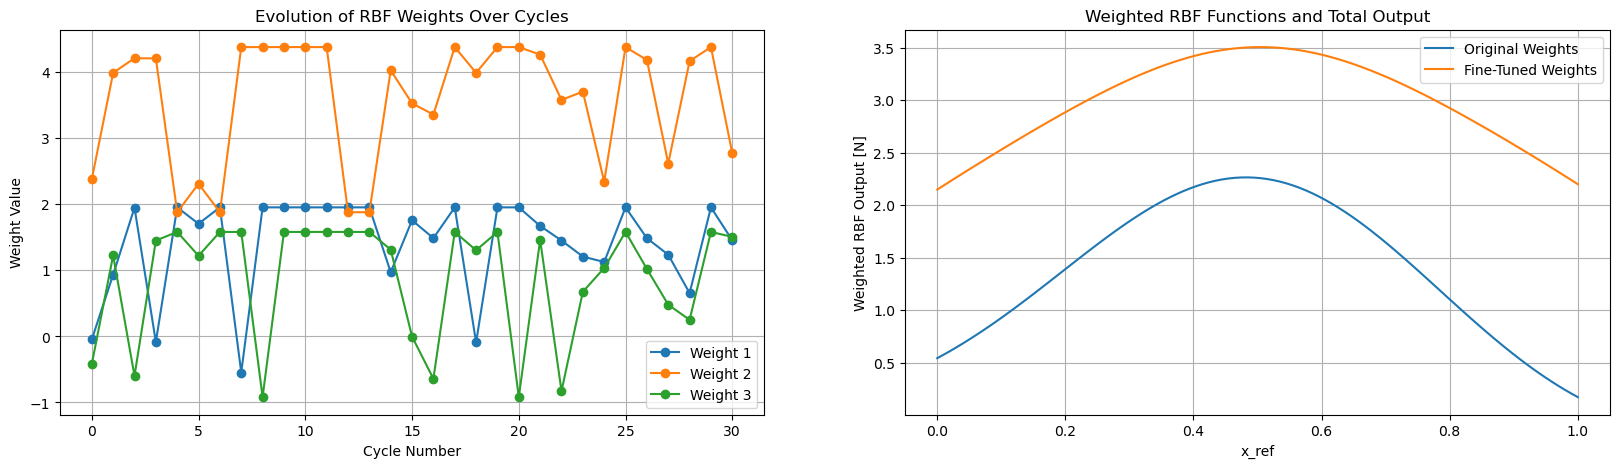

In [13]:
plt.figure(figsize=(20, 10))
plt.suptitle(f'Human "{human_type}" Bayesian Optimization Fine-Tuning', fontweight="bold", fontsize=15, y=0.95)

# 1. Human Force Comparison
plt.subplot(2, 2, 1)
plt.plot(time_vector, data_lp_rbf.all_cycle_human[-1], label='Original')
plt.plot(time_vector, data_lp_rbf_bo.all_cycle_human[-1], label='Fine-Tuned')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Human Applied Force')
plt.legend()
plt.grid(True)

# 2. Trajectory Tracking
plt.subplot(2, 2, 2)
plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='Original')
plt.plot(time_vector, data_lp_rbf_bo.all_cycle_sim[-1], label='Fine-Tuned')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking')
plt.legend()
plt.grid(True)

# 3. Robot Force Comparison
plt.subplot(2, 2, 3)
plt.plot(time_vector, data_lp_rbf.all_cycle_robot[-1], label='Original')
plt.plot(time_vector, data_lp_rbf_bo.all_cycle_robot[-1], label='Fine-Tuned')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Robot Force')
plt.legend()
plt.grid(True)

# 1. Evolution of RBF Weights Over Cycles
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
x_range = range(n_finetune_cycles+1)
fine_tuned_weights = np.array([data_lp_rbf.all_cycle_weights[-1]]) + np.array(data_lp_rbf_bo.all_cycle_resist_weights)
fine_tuned_weights_from_origin = np.vstack([data_lp_rbf.all_cycle_weights[-1], fine_tuned_weights])

for i in range(n_rbf):
    plt.plot(x_range, fine_tuned_weights_from_origin[:, i], marker='o', label=f'Weight {i+1}')
plt.xlabel('Cycle Number')
plt.ylabel('Weight Value')
plt.title('Evolution of RBF Weights Over Cycles')
plt.legend()
plt.grid(True)

# 2. Total Weighted RBF Functions and Total Output
x_range = np.linspace(0, 1, 100)
phi_matrix = np.zeros((len(x_range), n_rbf))
for i, x_val in enumerate(x_range):
    phi_matrix[i, :] = compute_rbf_outputs(x_val, centers, sigma)

weighted_phi_matrix_original = np.sum(phi_matrix * data_lp_rbf.all_cycle_weights[-1], axis=1)
weighted_phi_matrix_fine_tuned = np.sum(phi_matrix * fine_tuned_weights_from_origin[-1], axis=1)

plt.subplot(1, 2, 2)
plt.plot(x_range, weighted_phi_matrix_original, label='Original Weights')
plt.plot(x_range, weighted_phi_matrix_fine_tuned, label='Fine-Tuned Weights')
plt.xlabel('x_ref')
plt.ylabel('Weighted RBF Output [N]')
plt.title('Weighted RBF Functions and Total Output')
plt.legend()
plt.grid(True)

plt.show()
